In [7]:

# transfering learning from pre-trained model for image classification task
# borrowing from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


# if labelling my own images: there's probably software to make manual object labelling much easier


from __future__ import print_function, division # forces py interpreter to use newer features of language re these funcs
# https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works/7075121

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler   # learning rate scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



'/Users/apple/Desktop/quant_py_notebooks/fluent_python'

In [14]:
data_transforms = {
    'train': transforms.Compose([        # chaining image transform operations
        transforms.RandomResizedCrop(224),  # crop random portion of image and resize it to given shape
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalise with set mean's and sd's
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/apple/Desktop/quant_py_notebooks/fluent_python/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}



In [15]:
print(image_datasets.keys()) 
print(image_datasets['val'])

# image_datasets is dict of pathways and operations on train and test, which arent
# yet loaded into memory
# In train and val folders, theres a separate folder for images of bees and ants: it seems a separate
# folder is neeed for each class

dict_keys(['train', 'val'])
Dataset ImageFolder
    Number of datapoints: 153
    Root location: /Users/apple/Desktop/quant_py_notebooks/fluent_python/data/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [31]:
# making dataloaders, storing as a dictionary
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=2) # set to use 2 threads
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('dataset_sizes: ' + str(dataset_sizes))
print('class_names: ' + str(class_names))
print('dataloaders length: ' + str(len(dataloaders)))

dataset_sizes: {'train': 244, 'val': 153}
class_names: ['ants', 'bees']
dataloaders length: 2


out.shape: torch.Size([3, 228, 906])
inputs.shape:  torch.Size([4, 3, 224, 224])
classes: tensor([0, 1, 1, 1])


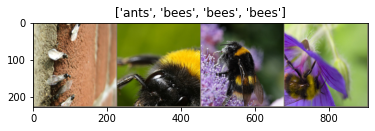

In [42]:
# View image in training set
def imshow(inp, title):
    """show an image after it goes through the specified transformations"""
    inp = inp.numpy().transpose((1, 2, 0))   # reorder dimensions
    mean = np.array([0.485, 0.456, 0.406])    
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                # adjust by specified params (asssume already normalised to sd=1)
                                        # so new sd becomes that which is set
    inp = np.clip(inp, 0, 1)            # all values <0 go to 0; all values >1 go to 1
    plt.imshow(inp)  
    plt.title(title)
   # plt.pause(0.001)  # pause a bit so that plots are updated: doesnt make difference if commented out


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make grid (concatenates 4 images horizontally, making one wide image)
out = torchvision.utils.make_grid(inputs)
print('out.shape: ' + str(out.shape))

imshow(out, title = [class_names[x] for x in classes])


print('inputs.shape: ', str(inputs.shape))
print('classes: ' + str(classes))

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """Runs main training process"""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())  # stores model parameters
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)   # make lines

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients : still not sure why zero_grad is needed every iter
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # recording loss and % correct
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()     # update learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # accuracy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model if this epoch is an improvement
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [50]:
### loading pretrained model and setting params for retraining from start (NOT transfer learning)
model_ft = models.resnet18(pretrained=True)


outer_input_features = model_ft.fc.in_features
print('number of features going in to output layer: ' + str(outer_input_features))


## Adding FC layer with 2 outputs (no activation func)
model_ft.fc = nn.Linear(outer_input_features, len(class_names)) 


# assigning it to device (changes nothing here - it just stays on CPU)
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()  # set loss function


# set gradient descent optimiser, inc learning rate and momentum (other params available)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# set learning rate to decay every 7 iterations
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### all params now set: need a function to define the training process next (see next cell)

number of features going in to output layer: 512


In [53]:
# run training: retraining whole model; 
## NOT transfer learning 

# takes slightly longer than if transfer learning (which we'll do later)
# takes a few mins just to do 2 epochs (and more if defo better)
## (only doing two epochs to save time; not that bothered about the result here)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)


Epoch 0/1
----------
train Loss: 0.5339 Acc: 0.6967
val Loss: 0.1910 Acc: 0.9412

Epoch 1/1
----------
train Loss: 0.4224 Acc: 0.8238
val Loss: 0.3320 Acc: 0.8693

Training complete in 3m 12s
Best val Acc: 0.941176


In [57]:
print(model_ft.training)  # think this tells you if the model is training right now, or in training mode

False


In [85]:
### prepping for transfer learning
model_pretrained = models.resnet18(pretrained=True)


# Apart from these two lines, the rest of the hyperparam initialisation stage is same as training
# all layers of resnet18 
for param in model_pretrained.parameters():  # this freezes parameters for existing layers, so not trained
    param.requires_grad = False
    print(param.shape) # show sizes of tensor parameters (aka weights)
    

# hyperparams
num_ftrs = model_pretrained.fc.in_features  # make new layer
model_pretrained.fc = nn.Linear(num_ftrs,  len(class_names))
model_pretrained = model_pretrained.to(device)
criterion = nn.CrossEntropyLoss()  # set loss function
optimizer_model_pretrained = optim.SGD(model_pretrained.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_model_pretrained, step_size=7, gamma=0.1)

torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.

In [70]:
# running training of final output layer: not much faster than training from scratch
model_transfer_trained = train_model(model_pretrained, criterion, optimizer_model_pretrained,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4607 Acc: 0.7869
val Loss: 0.1889 Acc: 0.9608

Epoch 1/9
----------
train Loss: 0.3728 Acc: 0.8279
val Loss: 0.2059 Acc: 0.9412

Epoch 2/9
----------
train Loss: 0.4905 Acc: 0.7787
val Loss: 0.2523 Acc: 0.8889

Epoch 3/9
----------
train Loss: 0.4577 Acc: 0.7951
val Loss: 0.2668 Acc: 0.8954

Epoch 4/9
----------
train Loss: 0.3912 Acc: 0.8402
val Loss: 0.2197 Acc: 0.9412

Epoch 5/9
----------
train Loss: 0.3287 Acc: 0.8443
val Loss: 0.2369 Acc: 0.9020

Epoch 6/9
----------
train Loss: 0.3791 Acc: 0.8279
val Loss: 0.2445 Acc: 0.8954

Epoch 7/9
----------
train Loss: 0.3500 Acc: 0.8402
val Loss: 0.2269 Acc: 0.9216

Epoch 8/9
----------
train Loss: 0.3283 Acc: 0.8484
val Loss: 0.2321 Acc: 0.9085

Epoch 9/9
----------
train Loss: 0.2898 Acc: 0.8730
val Loss: 0.2440 Acc: 0.8889

Training complete in 9m 19s
Best val Acc: 0.960784


In [ ]:
## (only doing a few epochs to save time; not that bothered about the result here)

In [117]:
## Preprocessing data to put through the model
print("type(image_datasets['val']: " + str(type(image_datasets['val']))) # imageFolder=generic data loader from folders

print('there are this many images in val dataset: ' + str(len(image_datasets['val'])))
single_image = image_datasets['val'][0]    # select a single image from the val group
image_tensor = single_image[0]
image_label = single_image[1]

<class 'torch.utils.data.dataloader.DataLoader'>
39
type(image_datasets['val']: <class 'torchvision.datasets.folder.ImageFolder'>
there are this many images in val dataset: 153


In [130]:
## Put single image through the model
x, y = image_tensor, image_label

model_transfer_trained.eval() 
softmax = nn.Softmax(dim=1)  # defining softmax for our uses
with torch.no_grad():    # anytime we're applying the model, put it within no_grad so no updates made
    pred = model_transfer_trained(x[None, ...])   # model(x) doesn't work, need [None,...] too 
                                # because pytorch expects a batch, not a single value
                                # https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but
    print(f'Raw predictions: "{pred}"')
    softmax_pred = softmax(pred)
    print(f'Activated predictions: "{softmax_pred}"')
    single_prediction = class_names[pred[0].argmax(0)]
    print(f'Class prediction: "{single_prediction}", vs actual of: "{class_names[y]}"')
    
    
    pred = model_transfer_trained(x[None, ...])
    print(f'Raw predictions on non-transfer model: "{pred}"') # these are the same, suggesting model might
                                    # have transferred some learning across after all: would need to check



Raw predictions: "tensor([[ 0.6316, -0.2919]])"
Activated predictions: "tensor([[0.7158, 0.2842]])"
Class prediction: "ants", vs actual of: "ants"
Raw predictions on non-transfer model: "tensor([[ 0.6316, -0.2919]])"
